##1. Cargue de la data

In [33]:
#Librerías
import pandas as pd
import numpy as np
from google.colab import drive

In [34]:
#Importar datos
drive.mount('/content/drive')

# Repositorio de las imágenes
datos = pd.read_csv("/content/drive/MyDrive/Colab/Prueba/datos_no_estructurados_02_Claudia_Pinzón/davivienda_tweets.csv")
datos.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


In [35]:
# Convertir la columna 'timestamp' a datetime
datos['Timestamp'] = pd.to_datetime(datos['Timestamp'])

# Crear nuevas columnas de fecha y hora
datos['fecha'] = datos['Timestamp'].dt.date
datos['hora'] = datos['Timestamp'].dt.time

datos.drop(['Timestamp', 'Unnamed: 0', 'UserName', 'Text', 'Image link'], axis=1, inplace=True)

print(datos[['fecha', 'hora']].head())

        fecha      hora
0  2021-12-01  20:43:12
1  2021-12-01  21:18:10
2  2021-12-01  22:49:11
3  2021-12-01  12:29:07
4  2021-12-01  20:52:36


In [36]:
#Eliminar filas vacías
datos = datos.apply(lambda x: pd.Series(x.dropna().values))

In [37]:
#Dimensiones de la data
datos.shape

(1811, 9)

##2. Limpieza de la base

In [38]:
#Librerías
import re
!pip install emoji
import emoji

In [39]:
#Eliminar links, menciones y hashtag
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['Embedded_text']

    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")

    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag, "")

    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention, "")

    return text, links, hashtags, mentions

In [40]:
datos[['texto_limpio', 'links', 'hashtags', 'mentions']] = datos.apply(text_clean, axis=1, result_type='expand')
datos.head(2)

,UserScreenName,Embedded_text,Emojis,Comments,Likes,Retweets,Tweet URL,fecha,hora,texto_limpio,links,hashtags,mentions
0,Andrés Langebaek,La confianza se afectó. El indicador de confia...,✅ ✅ ✅ ✅ ✅,1.0,7,19,https://twitter.com/ALangebaek/status/14661458...,2021-12-01,20:43:12,La confianza se afectó. El indicador de confia...,[],[],[]
1,Plaza Futura,Buscamos la accesibilidad y mejor atención en ...,📊,1.0,1,1,https://twitter.com/plaza_futura/status/146615...,2021-12-01,21:18:10,Buscamos la accesibilidad y mejor atención en ...,[],[],[]


In [41]:
#Eliminar emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

datos['tweets'] = datos['texto_limpio'].apply(remove_emojis)

print(datos[['tweets']].head(5))

                                              tweets
0  La confianza se afectó. El indicador de confia...
1  Buscamos la accesibilidad y mejor atención en ...
2  Señores \n\n no he podido ingresar a mi app da...
3  Llevo toda una semana sufriendo intento de hur...
4  Hemos retrocedido tanto en este país con este ...


##3. Pre-procesamiento de los tweets

In [42]:
#Librerías
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_sp = stopwords.words('spanish')

from nltk.stem.snowball import SnowballStemmer
spanishStemmer=SnowballStemmer("spanish")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import scipy.cluster.hierarchy as sch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
#Pre_procesamiento del texto

def pre_procesado(texto):
    texto = texto.lower() #pasar a minúsculas
    texto = re.sub(r"[\W\d_´]+", " ", texto) #eliminar caracteres especiales
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp]) #quitar palabras vacías
    texto = [palabra for palabra in texto.split() if palabra not in stopwords_sp] #quitar palabras vacías
    texto = [texto.lower() for texto in texto if len(texto) > 2 and texto.isalpha()] #quitar palabras de menos de 2 caracteres
    texto = " ".join(texto)
    return (texto)

datos['tweets_procesados']=datos['tweets'].apply(lambda texto: pre_procesado(texto))
datos.head(5)

,UserScreenName,Embedded_text,Emojis,Comments,Likes,Retweets,Tweet URL,fecha,hora,texto_limpio,links,hashtags,mentions,tweets,tweets_procesados
0,Andrés Langebaek,La confianza se afectó. El indicador de confia...,✅ ✅ ✅ ✅ ✅,1.0,7,19,https://twitter.com/ALangebaek/status/14661458...,2021-12-01,20:43:12,La confianza se afectó. El indicador de confia...,[],[],[],La confianza se afectó. El indicador de confia...,confianza afectó indicador confianza daviviend...
1,Plaza Futura,Buscamos la accesibilidad y mejor atención en ...,📊,1.0,1,1,https://twitter.com/plaza_futura/status/146615...,2021-12-01,21:18:10,Buscamos la accesibilidad y mejor atención en ...,[],[],[],Buscamos la accesibilidad y mejor atención en ...,buscamos accesibilidad mejor atención trámites...
2,Julián Martinez,Señores \n@Davivienda\n no he podido ingresar ...,👉,2.0,1,2,https://twitter.com/JulianM998/status/14661775...,2021-12-01,22:49:11,Señores \n\n no he podido ingresar a mi app da...,[],[],[@Davivienda],Señores \n\n no he podido ingresar a mi app da...,señores podido ingresar app davivienda ingreso...
3,Ferchis.,Llevo toda una semana sufriendo intento de hur...,🤣 🤣 🤣,3.0,1,8,https://twitter.com/fergomezr28/status/1466021...,2021-12-01,12:29:07,Llevo toda una semana sufriendo intento de hur...,[],[],"[@Davivienda, @Davivienda]",Llevo toda una semana sufriendo intento de hur...,llevo toda semana sufriendo intento hurto medi...
4,MirandaL2,Hemos retrocedido tanto en este país con este ...,✍,1.0,1,1,https://twitter.com/MirandaSuspLo/status/14661...,2021-12-01,20:52:36,Hemos retrocedido tanto en este país con este ...,[],[],[@Davivienda],Hemos retrocedido tanto en este país con este ...,retrocedido país gobierno malparidos cajeros d...


In [44]:
#Vectorización

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(datos.tweets_procesados.values)

#matriz tf-df
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names_out())

In [45]:
#Similitud entre tweets
from sklearn.metrics.pairwise import cosine_similarity

voc = [k for k,v in sorted(tfidf_vect.vocabulary_.items(), key=lambda kv: kv[1])]
temp = pd.DataFrame(tfidf.toarray())
temp = cosine_similarity(temp.values)
temp = pd.DataFrame(temp)
temp.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810
0,1.000000,0.004799,0.007411,0.028602,0.0,0.005753,0.007182,0.0,0.027422,0.002876,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0
1,0.004799,1.000000,0.008943,0.000000,0.0,0.031055,0.008667,0.0,0.000000,0.051676,...,0.0,0.000000,0.0,0.000000,0.0,0.028515,0.00000,0.025729,0.000000,0.0
2,0.007411,0.008943,1.000000,0.049788,0.0,0.010722,0.013384,0.0,0.049113,0.005359,...,0.0,0.036621,0.0,0.038593,0.0,0.000000,0.03882,0.000000,0.036737,0.0
3,0.028602,0.000000,0.049788,1.000000,0.0,0.015852,0.000000,0.0,0.034962,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,1.0,0.025287,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0


In [46]:
pairwise_distances = sch.distance.pdist(temp)
linkage = sch.linkage(pairwise_distances, method='ward')
idx_to_cluster_array = sch.fcluster(linkage, pairwise_distances.max() * 0.5, criterion='distance')
idx = np.argsort(idx_to_cluster_array)
temp = temp.copy()

temp2 = temp.iloc[idx, :].T.iloc[idx, :]
my_idx = idx_to_cluster_array

temp2.index = ['tweet #'+str(i) for i in temp2.columns]
temp2.columns = temp2.index
print(temp2.head(5))

             tweet #629  tweet #26  tweet #1589  tweet #1007  tweet #1002  \
tweet #629     1.000000   0.190110     0.101110     0.197135     0.180194   
tweet #26      0.190110   1.000000     0.094454     0.184157     0.168331   
tweet #1589    0.101110   0.094454     1.000000     0.097944     0.303270   
tweet #1007    0.197135   0.184157     0.097944     1.000000     0.174551   
tweet #1002    0.180194   0.168331     0.303270     0.174551     1.000000   

             tweet #1261  tweet #634  tweet #240  tweet #1050  tweet #1680  \
tweet #629      0.266288    0.163817    0.318989     0.102108     0.086147   
tweet #26       0.248757    0.153032    0.297988     0.095386     0.173048   
tweet #1589     0.132301    0.081390    0.158485     0.050731     0.042801   
tweet #1007     0.257949    0.158687    0.309000     0.098910     0.083449   
tweet #1002     0.235782    0.145050    0.282445     0.090410     0.076278   

             ...  tweet #1099  tweet #913  tweet #914  tweet #1698  

##4. Análisis de sentimiento

###4.1 Análisis con flair

In [49]:
#Librerías

from flair.models import TextClassifier
from flair.data import Sentence

from translate import Translator
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

import PIL.Image
from IPython.display import display

In [50]:
#Modelo de clasificación de sentimiento

classifier = TextClassifier.load('sentiment')

def sent_flair(texto):
    sentence = Sentence(texto) #conversión de texto en objeto
    classifier.predict(sentence) #predicción
    result = sentence.labels[0]
    label = result.value #etiquetas
    score = result.score #nivel de confianza de la predicción
    if label == 'POSITIVE':
        return score
    elif label == 'NEGATIVE':
        return -1 * score
    else:
      return 0

datos['sent_flair'] = datos['tweets_procesados'].apply(lambda valor: sent_flair(valor))
print(datos[['tweets_procesados', 'sent_flair']].head(5))

                                   tweets_procesados  sent_flair
0  confianza afectó indicador confianza daviviend...    0.999416
1  buscamos accesibilidad mejor atención trámites...    0.991091
2  señores podido ingresar app davivienda ingreso...    0.994608
3  llevo toda semana sufriendo intento hurto medi...    0.989160
4  retrocedido país gobierno malparidos cajeros d...   -0.937353


In [51]:
print("Tweet más positivo")
print(datos.loc[datos['sent_flair'].idxmax(), 'tweets_procesados'])

Tweet más positivo
acabo recibir súper oferta davivienda


In [52]:
print("Tweet más negativo")
print(datos.loc[datos['sent_flair'].idxmin(), 'tweets_procesados'])

Tweet más negativo
tener pyme davivienda terrible hoy dure medio día desbloqueado mierda casi después mes poderlo usar foto mandar correo logro


In [53]:
#Cantidad de tweets positivos y negativos
datos['sent_flair_label'] = datos['sent_flair'].apply(lambda valor: 'POSITIVO' if valor > 0 else ('NEGATIVO' if valor < 0 else 'NEUTRAL'))
print(datos['sent_flair_label'].value_counts())

sent_flair_label
POSITIVO    1355
NEGATIVO     456
Name: count, dtype: int64


###4.2 Análisis con Vader

In [54]:
#Librerías
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob  import TextBlob
from datasets import load_dataset
from transformers import TrainingArguments, Trainer

In [55]:
tweets_blob = [TextBlob(tweet) for tweet in datos['tweets_procesados']]
datos['Polaridad'] = [b.sentiment.polarity for b in tweets_blob]
datos['Subjetividad'] = [b.sentiment.subjectivity for b in tweets_blob]

In [56]:
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(datos.tweets)

{'neg': 0.046, 'neu': 0.937, 'pos': 0.017, 'compound': -1.0}

In [57]:
analyzer = SentimentIntensityAnalyzer()

datos['Compound'] = [analyzer.polarity_scores(v)['compound'] for v in datos['tweets_procesados']]
datos['Neg'] = [analyzer.polarity_scores(v)['neg'] for v in datos['tweets_procesados']]
datos['Neu'] = [analyzer.polarity_scores(v)['neu'] for v in datos['tweets_procesados']]
datos['Pos'] = [analyzer.polarity_scores(v)['pos'] for v in datos['tweets_procesados']]

datos[['tweets_procesados',	'Compound',	'Neg',	'Neu',	'Pos']].head(10)

,tweets_procesados,Compound,Neg,Neu,Pos
0,confianza afectó indicador confianza daviviend...,0.0000,0.0,1.000,0.000
1,buscamos accesibilidad mejor atención trámites...,0.0000,0.0,1.000,0.000
2,señores podido ingresar app davivienda ingreso...,0.0000,0.0,1.000,0.000
3,llevo toda semana sufriendo intento hurto medi...,0.0000,0.0,1.000,0.000
4,retrocedido país gobierno malparidos cajeros d...,0.0000,0.0,1.000,0.000
5,open data ceo pregúntele gente pie importa acá...,0.0000,0.0,1.000,0.000
6,conoce requisitos convocatoria becas talento f...,0.0000,0.0,1.000,0.000
7,mamado ser adulto tener trabajar pagarle,0.0000,0.0,1.000,0.000
8,ayuda favor llevo meses tratando cambiar númer...,0.4019,0.0,0.881,0.119
9,cierto recuerdo vendieron empresas bavaria col...,0.0000,0.0,1.000,0.000


##4.3 Modelo transformers

In [58]:
#Librerías
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline

In [59]:
# Convertir datos en lista
tweets = datos["tweets_procesados"].tolist()

In [69]:
#Modelo preentrenado de BERT para tweets
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

#Función para realizar análisis de sentimiento
def analyze_sentiment(tweet):
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).tolist()[0]
    sentiment_label = "Positive" if probabilities[1] > probabilities[0] else "Negative"
    return sentiment_label, probabilities

results = []
for tweet in tweets:
    sentiment, probabilities = analyze_sentiment(tweet)
    results.append({"Tweet": tweet, "Sentiment": sentiment, "Probabilities": probabilities})

In [74]:
#Resultados del modelo para la data

datos['analyze_sentiment'] = [result['Sentiment'] for result in results]
datos['analyze_probabilities'] = [result['Probabilities'] for result in results]
print(datos[['tweets_procesados', 'analyze_sentiment', 'analyze_probabilities']].head(5))

                                   tweets_procesados analyze_sentiment  \
0  confianza afectó indicador confianza daviviend...          Positive   
1  buscamos accesibilidad mejor atención trámites...          Positive   
2  señores podido ingresar app davivienda ingreso...          Positive   
3  llevo toda semana sufriendo intento hurto medi...          Positive   
4  retrocedido país gobierno malparidos cajeros d...          Positive   

                       analyze_probabilities  
0  [0.46477994322776794, 0.5352200269699097]  
1   [0.4607606828212738, 0.5392392873764038]  
2  [0.46146655082702637, 0.5385334491729736]  
3   [0.4683390259742737, 0.5316609144210815]  
4   [0.46443408727645874, 0.535565972328186]  


##6. Agrupación por Clusters

In [75]:
#Librerías
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Módulos para gráfico
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

In [76]:
ks = []
k_inertias = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_

    ks.append(k)
    k_inertias.append(k_inertia)

list(zip(ks,k_inertias))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

[(1, 1781.4449855926114),
 (2, 1726.4666448761004),
 (3, 1716.3248243495964),
 (4, 1701.6074602424046),
 (5, 1695.558062650491),
 (6, 1690.28539257347),
 (7, 1668.9586806204352),
 (8, 1664.870456041516),
 (9, 1654.566217218579)]

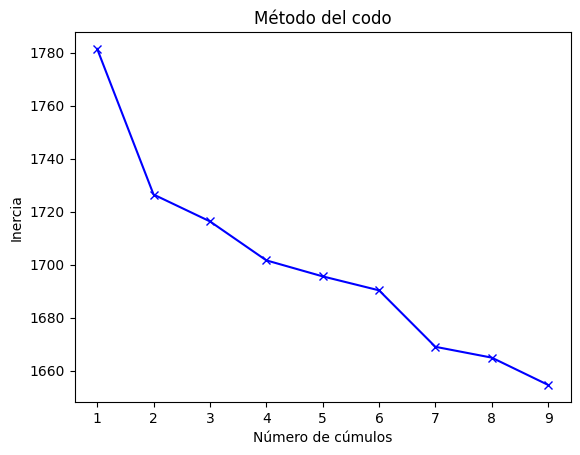

In [77]:
# Método del codo
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-')

In [78]:
#Entrenamiento del modelo
k = 7
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=7)

In [79]:
datos['tweets_preprocesados'] = model.labels_

In [82]:
#los vecinos más cercanas al centroide
#entrenamiento con matriz tfif
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

#porcentaje de los datos de cada clase
clust_cnt = datos['tweets_preprocesados'].value_counts()
clust_cnt_pct = datos['tweets_preprocesados'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names_out()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"CLUSTER #{i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")

    print("Palabras más importantes: ")
    for ind in order_centroids[i][:10]:
        print(terms[ind], end=" ")
    print()

    print("********************************************")
    print()

CLUSTER #0
Tiene 38 registros (2.10% de los datos)
Palabras más importantes: 
continuamente trabajamos podamos mejorar experiencia ayudar quedamos brindar detallar atentos 
********************************************

CLUSTER #1
Tiene 96 registros (5.30% de los datos)
Palabras más importantes: 
mensaje privado atentos caso respuesta favor envíenos interno quedamos feliz 
********************************************

CLUSTER #2
Tiene 180 registros (9.94% de los datos)
Palabras más importantes: 
respondiendo solución gracias hermano problema dan nadie respuesta discapacitado muchas 
********************************************

CLUSTER #3
Tiene 222 registros (12.26% de los datos)
Palabras más importantes: 
pasa tarjeta ustedes crédito plata respuesta cuenta cajero banco siempre 
********************************************

CLUSTER #4
Tiene 1104 registros (60.96% de los datos)
Palabras más importantes: 
respuesta davivienda banco app cuenta dinero servicio hacer daviplata hace 
********